### Import neccesary libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    mean_absolute_percentage_error as mape,
    root_mean_squared_error as rmse,
    mean_absolute_error as mae,
)
from sklearn.linear_model import LinearRegression

plt.style.use("default")

### Define the split type and stock name


In [2]:
split_type = [0.8,0.7,0.9]
# Stock [0] = FPT | [1] = CMG | [2] = ITD
stock_name = ["FPT", "CMG", "ITD"]

In [3]:
split = 2 
stock = 2 # ITD

## 1.Data preprocessing


In [4]:
# Loading data
df = pd.read_csv(f"../../Dataset/{stock_name[stock]}_stock.csv")
df

,time,open,high,low,close,volume,ticker
0,2019-03-01,6900,6900,6900,6900,37940,ITD
1,2019-03-04,6900,7100,6900,7100,36140,ITD
2,2019-03-05,7100,7100,6900,7100,14270,ITD
3,2019-03-06,6940,7230,6940,7170,224810,ITD
4,2019-03-07,7270,7270,7100,7170,80680,ITD
...,...,...,...,...,...,...,...
1308,2024-05-27,11300,11600,11300,11300,47400,ITD
1309,2024-05-28,11650,12050,11400,12050,322600,ITD
1310,2024-05-29,12850,12850,12450,12600,334600,ITD
1311,2024-05-30,12600,12600,12100,12500,299000,ITD


<Axes: >

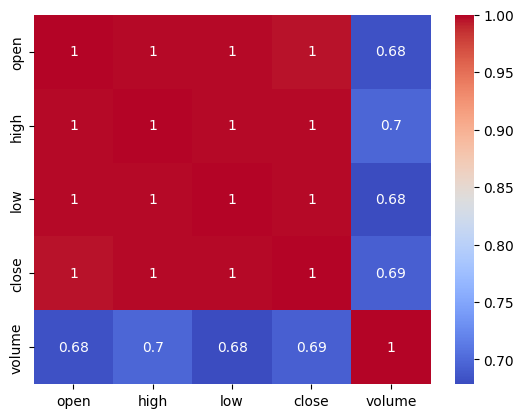

In [5]:
# Create a correlation matrix
df1 = df.drop(columns=["time", "ticker"], axis=1)
corr_matrix = df1.corr()

# Draw the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

#### Low price and close price are correlated => Good for forecast the "close price" in SARIMAX model

In [6]:
df = df[["low", "close"]] # Using low and close price to predict the next day close price, the low price is the exogenous variable

df

,low,close
0,6900,6900
1,6900,7100
2,6900,7100
3,6940,7170
4,7100,7170
...,...,...
1308,11300,11300
1309,11400,12050
1310,12450,12600
1311,12100,12500


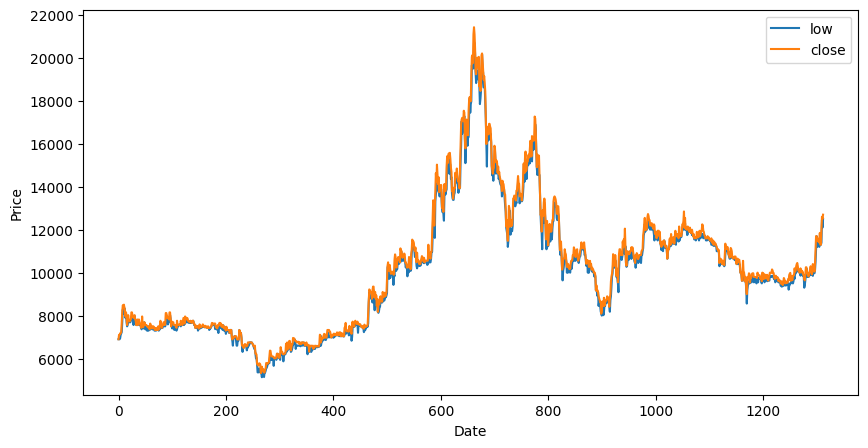

In [7]:
df.plot(figsize=(10, 5))
plt.ylabel("Price")
plt.xlabel("Date")
plt.show()

In [8]:
df.reset_index(drop=True)
df

,low,close
0,6900,6900
1,6900,7100
2,6900,7100
3,6940,7170
4,7100,7170
...,...,...
1308,11300,11300
1309,11400,12050
1310,12450,12600
1311,12100,12500


In [9]:
# Shape of the dataframe
df.shape

(1313, 2)

In [10]:
df.dtypes

low      int64
close    int64
dtype: object

In [11]:
# Describe the dataframe
df.describe()

,low,close
count,1313.000000,1313.000000
mean,9972.168317,10160.894897
std,2917.997297,3002.802575
min,5130.000000,5320.000000
25%,7460.000000,7550.000000
50%,9900.000000,10040.000000
75%,11500.000000,11650.000000
max,20700.000000,21430.000000


## 2. Train model


In [12]:
# Defining the split size
train_size = int(split_type[split] * len(df))
test_size = len(df) - train_size

In [13]:
# splitting data into train, test set
train_data = df[:train_size]
test_data = df[train_size:]

In [14]:
# splitting sets into independent and dependent variable
X_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data["close"])

X_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data["close"])

In [15]:
# Check if the dataset is stationary or not
from statsmodels.tsa.stattools import adfuller

adfuller(df["close"])

(-1.584523707127448,
 0.4913629480785365,
 12,
 1300,
 {'1%': -3.435390199468821,
  '5%': -2.8637658312426035,
  '10%': -2.567955046745562},
 18249.61406238007)

The high p-value close to 1 suggests that we fail to reject the null hypothesis -> the data is likely non-stationary.


In [16]:
# Agugmented Dickey-Fuller test
def adf_test(dataset, name):
    dftest = adfuller(dataset, autolag="AIC", regression="ct")
    print(f"ADF Test on '{name}' -> p-value: {dftest[1]:.3f}")
    if (
        dftest[0] < dftest[4]["5%"]
        or dftest[0] < dftest[4]["1%"]
        or dftest[0] < dftest[4]["10%"]
    ):
        print("\033[92mReject Ho - Time Series is Stationary\033[0m")
        return True
    else:
        print("\033[91mFailed to Reject Ho - Time Series is Non-Stationary\033[0m")
        return False

In [17]:
# Differencing all features for stationarity until all features are stationary
is_all_stationary = False
diff_order = 0
while not is_all_stationary:
    print("*" * 50 + f" Differencing of order {diff_order} " + "*" * 50)
    train_diff = pd.DataFrame(
        np.diff(train_data, diff_order, axis=0), columns=train_data.columns
    )
    if all([adf_test(train_diff[feature], feature) for feature in train_diff.columns]):
        is_all_stationary = True
        print(f"Dataset is stationary after differencing of order {diff_order}")
        break
    diff_order += 1

************************************************** Differencing of order 0 **************************************************
ADF Test on 'low' -> p-value: 0.745
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'close' -> p-value: 0.779
Failed to Reject Ho - Time Series is Non-Stationary
************************************************** Differencing of order 1 **************************************************
ADF Test on 'low' -> p-value: 0.000
Reject Ho - Time Series is Stationary
ADF Test on 'close' -> p-value: 0.000
Reject Ho - Time Series is Stationary
Dataset is stationary after differencing of order 1


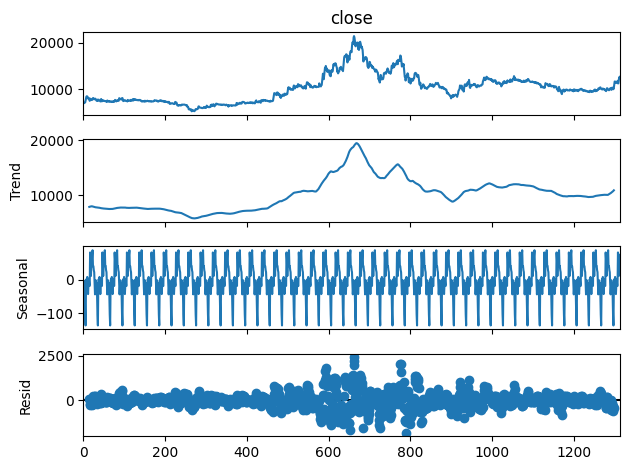

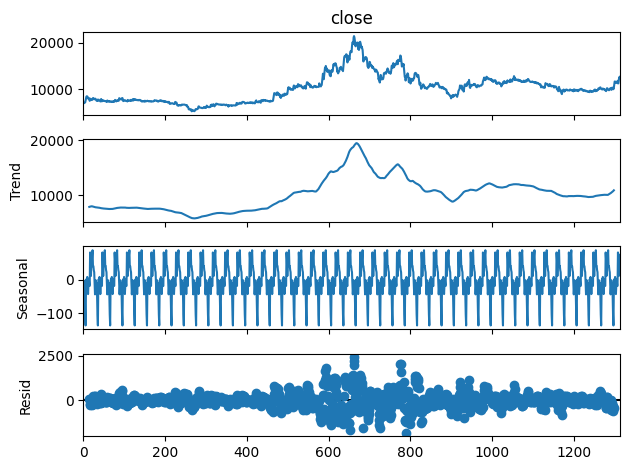

In [18]:
# Decompose the data to see the trend, seasonality and noise
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df["close"], model="additive", period=30)
decompose.plot()

In [19]:
df1 = df
df_diff = np.diff(train_data["close"], n=1)

In [20]:
# Check again
adfuller(df_diff)

(-10.25849866995158,
 4.297990989892184e-18,
 11,
 1168,
 {'1%': -3.4359610700352032,
  '5%': -2.8640177006421395,
  '10%': -2.568089182333693},
 16436.158642003014)

The p-value is less than 0.05 -> Dataset is stationary -> Draw ACF to find m


<Figure size 1000x600 with 0 Axes>

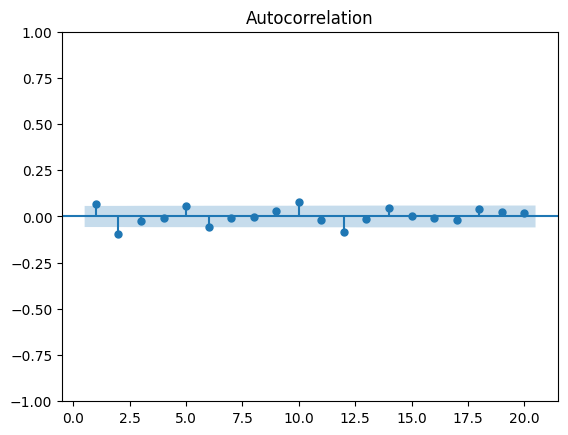

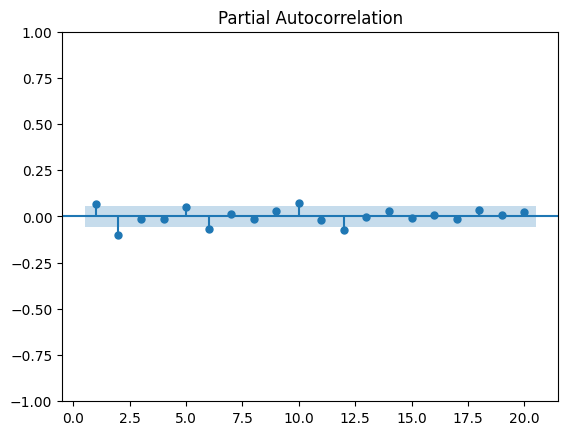

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10, 6))
plot_acf(df_diff, lags=20, zero=False)
plot_pacf(df_diff, lags=20, zero=False)
plt.show()

=> m = 5


In [22]:
# Review the dataset again
df

,low,close
0,6900,6900
1,6900,7100
2,6900,7100
3,6940,7170
4,7100,7170
...,...,...
1308,11300,11300
1309,11400,12050
1310,12450,12600
1311,12100,12500


In [23]:
# Use auto_arima to find the best (p, d, q) and (P, D, Q)
from pmdarima.arima import auto_arima

model = auto_arima(
    y_train,
    trace=True,
    d=1,
    max_p=7,
    max_d=7,
    error_action="ignore",
    suppress_warnings=True,
    seasonal=True,
    m=5,
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=16771.129, Time=1.01 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=16785.503, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=16780.163, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=16779.380, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=16783.594, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[5] intercept   : AIC=16773.582, Time=0.36 sec
 ARIMA(2,1,2)(1,0,0)[5] intercept   : AIC=16772.856, Time=0.26 sec
 ARIMA(2,1,2)(2,0,1)[5] intercept   : AIC=16769.241, Time=1.11 sec
 ARIMA(2,1,2)(2,0,0)[5] intercept   : AIC=16768.552, Time=1.39 sec
 ARIMA(1,1,2)(2,0,0)[5] intercept   : AIC=16767.947, Time=0.43 sec
 ARIMA(1,1,2)(1,0,0)[5] intercept   : AIC=16771.535, Time=0.17 sec
 ARIMA(1,1,2)(2,0,1)[5] intercept   : AIC=16768.017, Time=0.82 sec
 ARIMA(1,1,2)(1,0,1)[5] intercept   : AIC=16770.229, Time=0.74 sec
 ARIMA(0,1,2)(2,0,0)[5] intercept   : AIC=16766.663, Time=0.18 sec
 ARIMA(0,1,2)(1,0,0

In [24]:
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 1181
Model:             SARIMAX(0, 1, 2)x(2, 0, [], 5)   Log Likelihood               -8377.370
Date:                            Thu, 20 Jun 2024   AIC                          16764.740
Time:                                    07:08:05   BIC                          16790.106
Sample:                                         0   HQIC                         16774.303
                                           - 1181                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0747      0.020      3.807      0.000       0.036       0.113
ma.L2         -0.0908      0.020   

#### Use SARIMAX to train model


In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use 'low price' for the exogenous variable
model1 = SARIMAX(
    y_train,
    exog=np.array(train_data["low"]),
    order=(0, 1, 2),
    seasonal_order=(2, 0, 0, 5),
)

model_fit = model1.fit()

### Test


In [26]:
exg = np.array(test_data["low"])

y_pred_test = model_fit.predict(
    start=len(y_train), end=len(y_test) + len(y_train) - 1, exog=exg
)

y_pred_test

array([ 9990.47306122,  9917.61203375,  9744.01203047,  9771.58177058,
        9940.06927708,  9799.71682275,  9776.21867902,  9688.66332958,
        9800.72042416,  9886.39159544,  9740.07149826,  9941.9638972 ,
        9940.57810547,  9992.43574397,  9890.90226161,  9939.8179376 ,
        9741.27975474,  9690.79006949,  9891.36633112,  9900.3679174 ,
        9900.50715838,  9890.737995  ,  9740.84196373,  9800.93066111,
        9890.62147066,  9890.56983946,  9890.65560736,  9790.76458968,
        9990.52647833,  9820.71322669,  9820.71807043,  9820.73726792,
       10050.37644042, 10040.40732874,  9990.46787367,  9990.46506813,
       10040.39552359, 10040.3921347 , 10040.39728802,  9940.54404966,
        9890.62027489,  9900.60668426,  9740.84940607,  9810.74414543,
        9960.51442373,  9980.48380837,  9790.77361144,  9870.65153742,
        9740.84987739,  9740.84944803,  9770.80376558,  9790.77345053,
        9591.07788934,  9591.07799846,  9541.15401459,  9571.10832739,
      

### Forecast the next 30/60/90 days


In [27]:
num_of_days_30 = 30
num_of_days_60 = 60
num_of_days_90 = 90

In [28]:
df

,low,close
0,6900,6900
1,6900,7100
2,6900,7100
3,6940,7170
4,7100,7170
...,...,...
1308,11300,11300
1309,11400,12050
1310,12450,12600
1311,12100,12500


In [29]:
from sklearn.linear_model import LinearRegression

ln_model = LinearRegression()

# Use LM to find the low price the next 30/60/90 days
ln_model.fit(np.array(train_data.index).reshape(-1, 1), train_data["low"])

last_index = df.index[-1]
last_data_30 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_30, step=1)
last_data_60 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_60, step=1)
last_data_90 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_90, step=1)

# Create an array of 30/60/90 consecutive integers starting from last_index
x_30_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_30 + 1)
).reshape(-1, 1)

x_60_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_60 + 1)
).reshape(-1, 1)

x_90_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_90 + 1)
).reshape(-1, 1)

# Predict the low price - extrapolation variable for the next 30/60/90 days to predict the closeing price
low_30_days_pred = ln_model.predict(x_30_days_pred)
low_60_days_pred = ln_model.predict(x_60_days_pred)
low_90_days_pred = ln_model.predict(x_90_days_pred)

# Predict the closing prices of FPT for the next 30/60/90 days
y_30_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_30_days_pred) - 1,
    exog=low_30_days_pred,
)

y_60_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_60_days_pred) - 1,
    exog=low_60_days_pred,
)

y_90_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_90_days_pred) - 1,
    exog=low_90_days_pred,
)

# Print the predicted closing prices for the next 30 days
print("Forecast closing prices for the next 30 days:")
print(y_30_days_pred)

Forecast closing prices for the next 30 days:
[13904.39235213 13926.56182336 13917.8857396  13940.63823437
 13934.56733069 13919.19969826 13940.80818122 13938.29855607
 13955.67543568 13946.66639199 13955.28543994 13962.64987988
 13966.43161721 13973.53291276 13977.0147035  13981.17403655
 13987.49887082 13992.10058666 13998.14888928 14002.33323023
 14007.64000028 14013.02314037 14018.06625422 14023.41383424
 14028.40920323 14033.5251011  14038.77839806 14043.90265348
 14049.13658314 14054.23202542]


### Plotting the data


In [30]:
def draw_plot(x_next_days, y_next_day, days):
    plt.figure(figsize=(10, 6))
    plt.plot(train_data.index, train_data["close"], label="Train")
    plt.plot(test_data.index, test_data["close"], label="Test")

    plt.plot(test_data.index, y_pred_test, label="Predicted Test", linestyle="--")

    plt.plot(
        x_next_days, y_next_day, label=f"Next {days} days", linestyle="--"
    )
    plt.title(f"Forecast {stock_name[stock]} Stock Price Using SARIMAX")
    plt.legend()
    plt.show()

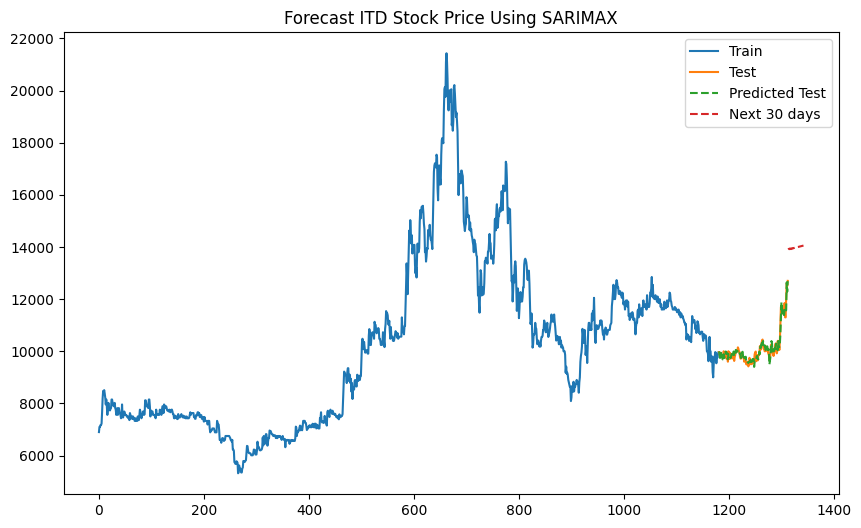

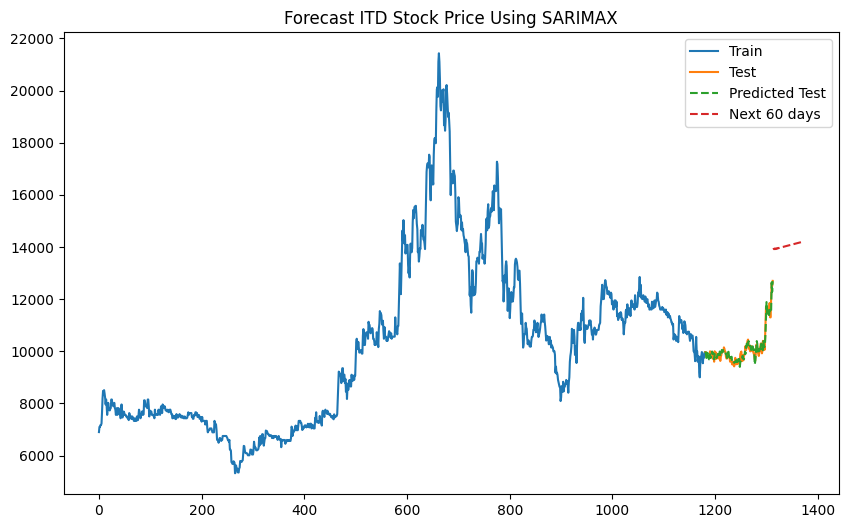

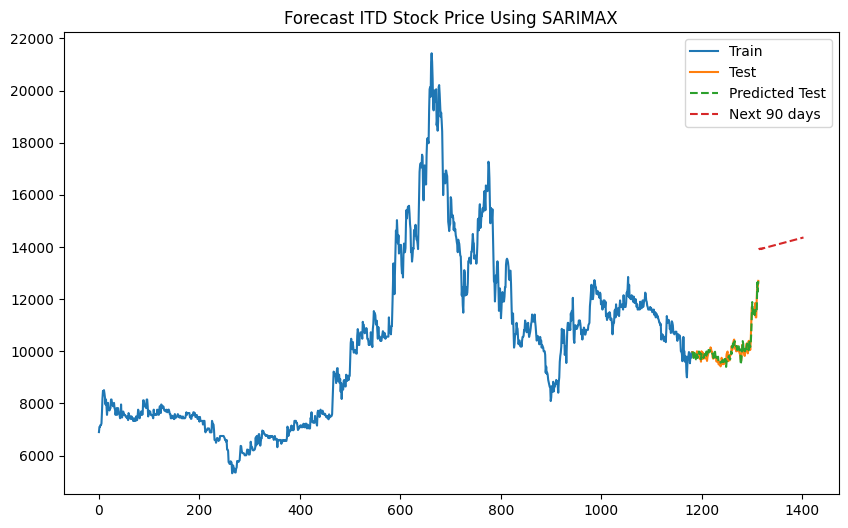

In [31]:
draw_plot(x_30_days_pred, y_30_days_pred, 30)
draw_plot(x_60_days_pred, y_60_days_pred, 60)
draw_plot(x_90_days_pred, y_90_days_pred, 90)

## 3. Model evaluation


In [32]:
# Model evaluation on test set
print(f"RMSE: {rmse(y_test, y_pred_test)}")
print(f"MAE: {mae(y_test, y_pred_test)}")
print(f"MAPE: {mape(y_test, y_pred_test) * 100} %")

RMSE: 150.45200645107406
MAE: 121.82755782179044
MAPE: 1.2013422873215982 %
